<div style="border:solid Green 2px; border-radius: 10px;  padding: 40px">
<b>Привет, Иван!👋</b>
    
Меня зовут Зуева Юлия, можно просто Юля 😏 Я буду ревьюером твоего проекта. Предлагаю обращаться на "ты", но если это неудобно, пожалуйста, скажи об этом! 
    
Моя основная цель - помочь тебе стать компетентным Data Scientist'ом: вместе преодолеть трудности и еще больше развить твои сильные навыки 💪 В твоей работе я оставила комментарии, которые должны в этом помочь. Для твоего удобства комментарии раскрашены разными цветами: 
<br/>
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> В случае корректного решения (или отдельных его моментов). На такие решения можно опираться в будущем.
</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> Если есть возможность как-либо улучшить решение. Ты можешь учесть эти комментарии при доработке проекта, однако для зачета это не обязательно.
</div>
<div style="border-radius: 10px" class="alert alert-block alert-danger">
<b>Нужно доработать ❌:</b> Если решение требует внесения правок. Проект не может быть принят, если остались не отработанные комментарии данного типа.
</div>
    
Чтобы наша с тобой работа была еще эффективнее, ты точно так же можешь оставлять комментарии и задавать мне вопросы. Для таких случаев, пожалуйста, выбери собственное оформление комментариев, которое будет отличаться от моего, чтобы не создавалась путаница. По этой же причине попрошу тебя не удалять и не изменять мои комментарии. Все это позволит лучше ориентироваться в нашем с тобой диалоге, а повторную проверку (в случае ее необходимости) выполнять оперативнее 🚀
    
Не спеши расстраиваться, если что-то не удалось с первого раза. Вместе мы обязательно разберемся со всеми трудностями! 🤓

<div style="border:solid #D3D3D3 2px; border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Вводная часть <a class="tocSkip"></h4>
    
<div style="border-radius: 10px" class="alert alert-block alert-danger">
<b>Нужно доработать ❌:</b> Любой проект должен начинаться с зголовка и введенеия. Они помогают быстро понять цель, контекст и структуру работы, что будет удобно не только для тебя при возвращении к проекту спустя время, но и любому другому читателю (если, например, публикуешь в открытый доступ для портфолио). Воспринимаем эту тетрадку не просто как выполнение домашней работы на курсе, а как полноценный исследовательский проект.


Как правило, во вводную часть включают название проекта, краткое описание цели, используемых данных (источники, объем, особенности), нюансы самого проекта (специфические условия, ограничения, предположения и т.д.). Другими словами, вводная часть призвана отразить, что мы делаем, с чем работаем и на каких условиях.

</div>

# Исправление

# Анализ лояльности пользователей Яндекс Афиши

## Введение

В данном проекте проводится анализ поведения пользователей сервиса Яндекс Афиша с целью изучения факторов, влияющих на возврат клиентов и количество повторных покупок.

Команда маркетинга заинтересована в том, чтобы лучше понимать, какие пользователи с большей вероятностью возвращаются на платформу и совершают повторные заказы. Результаты исследования могут быть использованы для:
- выявления перспективных пользователей и предложения им персонализированных условий;
- более точной настройки маркетинговых кампаний;
- оптимизации маркетинговых бюджетов;
- повышения общего уровня удержания клиентов.

В рамках проекта используется выборка данных о заказах пользователей, выгруженная из базы данных с помощью SQL. Данные содержат информацию о заказах, выручке, количестве билетов, временных характеристиках, а также признаках первого заказа пользователя.

### Описание данных

В анализе используются следующие основные поля:
- 'user_id' — уникальный идентификатор пользователя;
- 'device_type_canonical' — тип устройства первого заказа (mobile / desktop);
- 'order_id' — уникальный идентификатор заказа;
- 'order_dt', 'order_ts' — дата и время оформления заказа;
- 'currency_code' — валюта оплаты;
- 'revenue' — выручка с заказа;
- 'tickets_count' — количество купленных билетов;
- 'days_since_prev' — число дней с предыдущей покупки;
- 'event_type_main' — тип мероприятия;
- 'service_name' — билетный оператор;
- 'region_name', 'city_name' — регион и город проведения мероприятия.

### Структура исследования

Проект состоит из следующих этапов:
1. Загрузка данных и их первичная проверка.
2. Предобработка данных, включая приведение выручки к единой валюте и обработку выбросов.
3. Построение профиля пользователя и расчёт агрегированных метрик.
4. Исследовательский анализ факторов, влияющих на возврат пользователей.
5. Корреляционный анализ связи характеристик пользователя с количеством заказов.
6. Формирование итоговых выводов и рекомендаций для бизнеса.


# Ссылка на GitHub репозиторий
https://github.com/v4n99/DataScienceProject

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Публикация в Git <a class="tocSkip"></h4>

    
<div style="border-radius: 10px" class="alert alert-warning">
    
<b>Рекомендации💡:</b> Сейчас работу с Git сделали необязательной, но отмечу довольно критичные моменты.

* <span style="color:Red;">В репозитории не должно быть опубликовано данных и ключей для доступа к ним (как в '.env', так и в самой тетрадке, в том числе в тексте задания), это считается засекреченной информацией. Можно оставить лишь 'env_exaple', чтобы читатели, желающие запустить код, вставили туда свои собственные ключи. Сам '.env необходимо отправить в игнорирование.</span>


* В 'requirements.txt' не принято дозволять как более новые, так и более старые версии библиотек. В какой-то момент это может привести к конфликту версий. Поэтому необходимо указывать ровно то, что было использовано.


* Можно заполнить 'readme' полезной информацией о проекте, зафиксировать цели, указать ключевые моменты и полученные выводы.

</div>


In [144]:
!pip install phik -q

import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from phik import phik_matrix
import psycopg2
from dotenv import load_dotenv
import os

<div style="border:solid #D3D3D3 2px; border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Импорты <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b>

* Напомню, что перед отправкой проекта важно сбрасывать ядро (очищать память от созданных объектов) и заново запускать проект с самого начала, чтобы проверить на наличие ошибок в коде при последовательном исполнении ячеек. Сейчас этого сделано не было, нумерация ячеек начинается не с 1.

    
* Все необходимые библиотеки нужно подгружать сразу в начале проекта, это соответствует стандартам оформления кода <a href='https://pyplanet.ru/article/pep-0008.html'>PEP 8</a>. Такой подход позволяет сразу видеть, какое окружение необходимо для запуска проекта, избежать дублирования импортов в разных частях кода, а также облегчить отладку и переносимость проекта. Импорты не должны дублироваться, не должны импортироваться неиспользуемые библиотеки и методы.
    
    
* Хорошей практикой также является упорядочивание импортов. PEP 8 рекомендует сначала подгружать стандартные python-библиотеки, затем сторонние. Но для удобства каждую их этих групп также можно структурировать по тематике. Например, библиотеки для работы с данными, для работы с графиками и т.д. Так удобнее поддерживать порядок в импортах от проекта к проекту, не подгружать лишнее.

    
</div>

In [145]:
load_dotenv()

user = os.getenv("user")
pwd = os.getenv("pwd")
host = os.getenv("host")
port = os.getenv("port")
db = os.getenv("db")

In [146]:
db_config = {'user': user, # имя пользователя
             'pwd': pwd, # пароль
             'host': host,
             'port': port, # порт подключения
             'db': db # название базы данных
             }

In [147]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [148]:
engine = create_engine(connection_string)

In [149]:
# Создание запроса

query = '''
-- Настройка параметра synchronize_seqscans важна для проверки
WITH set_config_precode AS (
    SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT
    user_id,
    device_type_canonical,
    order_id,
    created_dt_msk,
    created_ts_msk,
    currency_code,
    revenue,
    tickets_count,
    CASE
        WHEN prev_order_date IS NULL THEN NULL
        ELSE (created_dt_msk::date - prev_order_date)::int
    END AS days_since_prev,
    event_id,
    event_name_code AS event_name,
    event_type_main,
    service_name,
    region_name,
    city_name
FROM (
    SELECT
        p.user_id,
        p.device_type_canonical,
        p.order_id,
        p.created_dt_msk,
        p.created_ts_msk,
        p.currency_code,
        p.revenue,
        p.tickets_count,
        p.event_id,
        e.event_name_code,
        e.event_type_main,
        p.service_name AS service_name,
        r.region_name,
        c.city_name,
        LAG(p.created_dt_msk::date)
            OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk) AS prev_order_date
    FROM afisha.purchases p
    INNER JOIN afisha.events e   ON p.event_id = e.event_id
    INNER JOIN afisha.city c    ON e.city_id = c.city_id
    INNER JOIN afisha.regions r ON c.region_id = r.region_id
    WHERE p.device_type_canonical IN ('mobile', 'desktop')
      AND e.event_type_main != 'фильм'
) t
ORDER BY user_id, created_dt_msk;

'''

In [150]:
df = pd.read_sql_query(query, con=engine)

<div style="border:solid #D3D3D3 2px; border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Загрузка данных <a class="tocSkip"></h4>
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> Выгрузка данных проведена корректно! Была выполнена необходимая фильтрация данных, выгружены только необходимые для анализа данные. Отлично, что сразу подсчитываешь время между заказами для каждого пользователя.
    
</div>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> Сейчас ты явным образом прописываешь параметры подключения к БД. В таком виде выкладывать работу в публичный доступ небезопасно, кто-то сможет завладеть подключением, украсть или повредить данные. Лучше сразу в процессе работы держать чувствительные значения отдельно от основного содержания, иначе есть высокий риск забыть об этом нюансе. 
    
Чтобы засекретить подключение, необходимо сложить все параметры в '.env' файл (или другой конфигурационный файл вне Git) и указать его в '.gitignore':

'''python
DB_NAME="..."
DB_HOST="..."
DB_PORT="..."
DB_USER="..."
DB_PASSWORD="..."
'''
    
В самом проекте мы можем обращаться к сохраненным параметрам, для этого нам потребуются библиотеки 'dotenv', чтобы загрузить переменные окружения, и 'os', чтобы обратиться к ним:
    
'''python
import os
import dotenv
    
load_dotenv() # автоматически ищет .env в текущей директории
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
) 
'''

Также данный файл можно добавить в репозиторий и здесь на платформе. Для этого нужно нажать на лого jupyter hub, найти кнопку для создания нового файла, внести необходимое содержимое, переименовать файл нужным образом и сохранить.
    
</div>

In [151]:
# Выгрузка датасета
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [152]:
print('Датасет имеет строк:', len(df))
print('и столбцов: ', len(df.columns))

Датасет имеет строк: 290611
и столбцов:  15


Почти все типы данных указаны правильно, единственное столбец days_since_prev нужно сделать типом int, ведь количество дней не может быть дробным.

In [153]:
print('Типы столбцов:\n',df.dtypes)

Типы столбцов:
 user_id                          object
device_type_canonical            object
order_id                          int64
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object


In [154]:
# Изменение типа столбца с float64 на Int64, который также поддерживает пропуски.
df['days_since_prev'] = df['days_since_prev'].astype('Int64')

In [155]:
# Вывод измененных столбцов
print(df.dtypes)

user_id                          object
device_type_canonical            object
order_id                          int64
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                   Int64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object


In [156]:
# Подсчет количество пропусков в столбцах
for column in df.columns:
    print(f"Столбец {column} имеет {df[column].isna().sum()} пропусков")

Столбец user_id имеет 0 пропусков
Столбец device_type_canonical имеет 0 пропусков
Столбец order_id имеет 0 пропусков
Столбец created_dt_msk имеет 0 пропусков
Столбец created_ts_msk имеет 0 пропусков
Столбец currency_code имеет 0 пропусков
Столбец revenue имеет 0 пропусков
Столбец tickets_count имеет 0 пропусков
Столбец days_since_prev имеет 21933 пропусков
Столбец event_id имеет 0 пропусков
Столбец event_name имеет 0 пропусков
Столбец event_type_main имеет 0 пропусков
Столбец service_name имеет 0 пропусков
Столбец region_name имеет 0 пропусков
Столбец city_name имеет 0 пропусков


In [157]:
print(f"Датасет имеет {df.duplicated().sum()} явных дубликатов")

Датасет имеет 0 явных дубликатов


Сделаем проверку на неявные дубликаты

In [158]:
# Найдем нечисловые столбцы
not_num_columns = [column for column in df.columns if (df[column].dtype == 'object') or (df[column].dtype == 'datetime64[ns]') ]

In [159]:
for column in not_num_columns:
    s = (
        df[column]
        .astype(str)
        .str.strip()
        .str.lower()
    )
    print(f'Столбец {column} имеет: {s.nunique()} уникальных значений')


Столбец user_id имеет: 21933 уникальных значений
Столбец device_type_canonical имеет: 2 уникальных значений
Столбец created_dt_msk имеет: 153 уникальных значений
Столбец created_ts_msk имеет: 280753 уникальных значений
Столбец currency_code имеет: 2 уникальных значений
Столбец event_name имеет: 15248 уникальных значений
Столбец event_type_main имеет: 7 уникальных значений
Столбец service_name имеет: 36 уникальных значений
Столбец region_name имеет: 81 уникальных значений
Столбец city_name имеет: 352 уникальных значений


# Вывод
- Датасет имеет 290611 строк и 15 столбцов
- Почти все типы данных указаны правильно, единственное столбец days_since_prev был сделан типом int, ведь количество дней не может быть дробным.
- В датасете 0 прямых дубликатов строк
- Столбец **user_id** содержит **21 933 уникальных значения**, что указывает на многократные события на одного пользователя (в среднем около 13 событий). Это соответствует событийной природе данных и не является признаком дублирования.
- Столбец **device_type_canonical** имеет **2 уникальных значения**, ведь мы сами выбрали только 2 устройства в запросе ранее.
- Столбец **created_dt_msk** содержит **153 уникальных значения**, что соответствует количеству дат в анализируемом периоде. Повторы значений ожидаемы и логичны.
- Столбец **created_ts_msk** имеет **280 753 уникальных значения**, то есть почти уникален относительно общего числа строк. Наличие повторов объясняется совпадением временных меток у разных событий и не указывает на ошибку, однако столбец не может использоваться как гарантированно уникальный ключ.
- Столбец **currency_code** содержит **2 уникальных значения**, что является допустимым и ожидаемым для финансовых данных.
- Столбец **event_type_main** имеет **7 уникальных значений**, что соответствует ограниченному набору основных типов событий и является нормальным для категориального признака.
- Столбец **event_name** содержит **15 248 уникальных значений**, что остаётся высоким показателем даже после нормализации. Это указывает на высокую детализацию или динамическую генерацию названий событий.
- Столбец **service_name** имеет **36 уникальных значений**, что является корректной размерностью и подходит для аналитических разрезов.
- Столбец **region_name** содержит **81 уникальное значение**, а **city_name** — **352 уникальных значения**. С учётом выполненной нормализации это говорит о корректном отражении географической структуры.


<div style="border:solid #D3D3D3 2px; border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Проверка корректности загруженных данных <a class="tocSkip"></h4>
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> 

* Хорошо, что убеждаешь в корректности данных! Если при подгрузке возникли проблемы, а мы их не обнаружим, все последующие расчеты могут быть искажены.

    
* Круто, что не забываешь зафиксировать промежуточные наблюдения в выводах! Если потребуется вернуться к проекту спустя время, будет проще освежить в памяти все ключевые этапы работы, что и почему мы делали, что получили.

</div>
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b>
    
* Обрати внимание, что если не ограничивать количество выводимой информации, то вывод ограничится только при отображении, но в json (в виде которых хранятся jupyter-ноутбуки) на диске будут все данные, что будет тормозить открытие и работу тетрадки. Чтобы такого не происходило, следует ограничивать вывод несколькими строками: 'head', 'tail', 'sample'.
    
    
* Стоит предположить, что пропуски, скорее всего, образовались на первых заказах пользователей, в таком случае у них не существует предыдущего, от которого можно было бы посчитать количество дней.
    
    
* Дубликаты могут быть в том числе и неполные, например, если заказ пользователя задублировался в системе, был создан в нескольких экземплярах с разным 'order_id' и, возможно, даже с небольшой разницей во времени, за которое человек не успел бы вручную произвести еще одну покупку. Чтобы не искажать статистические расчеты, от таких наблюдений тоже важно избавляться. Но для начала нужно проверить их наличие - для этого необходимо проверить, есть ли дубликаты на подвыборке без 'order_id' и 'days_since_prev'. Если обнаружим их и примем решение удалить, то потребуется также пересчитать признак с количеством дней между заказами.
    
    
* По результатам проверки корректности загруженных данных мы планируем дальнейшие шаги по обработке. Здесь можно было бы отметить, что нам потребуется привести выручку к единой валюте, убедиться, что пропуски действительно имеются только у первых заказов, выполнить проверку на дубликаты (полные и неполные), проверить категориальные столбцы на предмет неявных дубликатов (разный регистр, разный формат записи, опечатки) и все числовые столбцы на наличие невалидных значений и аномалий, опционально сменить типы данных на более оптимальные, чтобы уменьшить объем занимаемой памяти.
    
</div>

In [160]:
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [161]:
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [162]:
tenge_df.dtypes

data        object
nominal      int64
curs       float64
cdx         object
dtype: object

In [163]:
tenge_df['data'] = pd.to_datetime(tenge_df['data']).dt.normalize()

## Приведем выручку к единой валюте - российскому рублю

In [164]:
# Преобразуем курс на 1 тенге и создаем словарь: дата - курс
kurs_dict = pd.Series(tenge_df['curs'].values / 100, index=tenge_df['data']).to_dict()

In [165]:
# Создаем новый столбец revenue_rub
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        kurs = kurs_dict.get(row['created_dt_msk'])  # ищем по дате
        if kurs is not None:
            return round(row['revenue'] * kurs, 4)
        else:
            return None  # если дата курса не найдена
    else:
        return None

In [166]:
df['revenue_rub'] = df.apply(convert_to_rub, axis=1)

In [167]:
df[df['currency_code'] == 'rub'][
    ['created_dt_msk', 'revenue', 'currency_code', 'revenue_rub']
].head(10)

,created_dt_msk,revenue,currency_code,revenue_rub
0,2024-08-20,1521.94,rub,1521.94
1,2024-07-23,289.45,rub,289.45
2,2024-10-06,1258.57,rub,1258.57
3,2024-07-13,8.49,rub,8.49
4,2024-10-04,1390.41,rub,1390.41
5,2024-10-23,902.74,rub,902.74
6,2024-08-15,917.83,rub,917.83
7,2024-09-29,47.78,rub,47.78
8,2024-10-15,74.84,rub,74.84
9,2024-06-20,1421.91,rub,1421.91


<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Перевод выручки в рубли <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> С шагом справились, результат корректный!
</div>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Сперва следовало убедиться в корректности данных с курсом, по всем ли датам есть курс, адекватные ли там значения, нет ли дубликатов, а уже потом переходить к конвертации.


* Вместо цикличного 'apply' (который за раз работает с одной строкой, и при этом еще вынужден каждый раз по еще одной таблице, что очень долшл и затратно) лучше использовать довольно удобный метод [where](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.where.html). Мы можем присоединить курс к нашей таблице с пользователями, применить данный метод к столбцу с выручкой и указать условие, которое будем проверять, а также альтернативный вариант значения. Если условие выполняется, то берется значение из столбца, если нет - альтернативное значение. Тогда расчет выручки в рублях будет выглядеть следующим образом:
    
    '''python
df['revenue_rub'] = df['revenue'].where(df['currency_code'] == 'rub', df['revenue'] * df['curs'] / 100)
'''

* После проведения каких-либо манипуляций с данными необходимо убеждаться, что все выполнилось корректно. Для проверки результата стоит вывести на обозрение только связанные с данной задачей столбцы, чтобы не перегружать читателя лишним. При этом проверить оба кейса, и когда корректировка требовалась, и когда нет, убедиться, что не образовалось пропусков.
    
 
* Это исследовательская работа, а не скрипт, поэтому важно фиксировать свой ход мыслей, пояснять свои шаги и делать выводы относительно результатов, то есть вести последовательный сторителлинг, что зачем и почему мы делаем, что по итогу получаем, достигли ли нужного нам результата.
    
   
* Моменты, поясненные ранее: количество строк при отображении таблиц.

</div>

# Исправление

## Предобработка данных
#### На этапе предобработки данных необходимо убедиться, что данные корректны и готовы для дальнейшего анализа.
#### В рамках этого этапа проводится проверка пропусков, типов данных, категориальных признаков и распределений числовых показателей.
#### Цель предобработки — устранить возможные искажения в данных и обеспечить корректность последующих выводов.

- Часть задачи была выполнена ранее (по изменению типов столбцов и по подсчету пропусков)

В результате проверки пропущенных значений было выявлено, что пропуски присутствуют только в столбце 'days_since_prev'.
Это ожидаемое поведение данных: для пользователей, совершивших только один заказ, невозможно рассчитать интервал между покупками.

Таким образом, пропуски в данном столбце не являются ошибкой данных и не требуют дополнительной обработки. Для пользователей с повторными заказами значения интервала между покупками заполнены корректно.


In [168]:
# Проверка категориальных столбцов
categorical_cols = [
    'currency_code', 'device_type_canonical', 'event_type_main',
    'service_name', 'region_name', 'city_name'
]

for col in categorical_cols:
    print(f'\nСтолбец {col}:')
    print(df[col].value_counts(dropna=False))



Столбец currency_code:
rub    285542
kzt      5069
Name: currency_code, dtype: int64

Столбец device_type_canonical:
mobile     232490
desktop     58121
Name: device_type_canonical, dtype: int64

Столбец event_type_main:
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: event_type_main, dtype: int64

Столбец service_name:
Билеты без проблем        63519
Лови билет!               41124
Билеты в руки             40343
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17774
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Мир касс                   2167
Быстробилет                2003
Выступления.ру             1616
Восьмёрка 

### Исправление

В ходе анализа категориальных признаков было проверено наличие некорректных или технических категорий, обозначающих пропуски или ошибки выгрузки.

Аномальных или некорректных значений в категориальных признаках обнаружено не было. Категории выглядят логично и могут быть использованы для дальнейшего анализа и сегментации пользователей.


In [169]:
# Нормализация категориальных данных для дальнейшей проверки на пропуски
for col in categorical_cols:
    # строки - нижний регистр + strip пробелов
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.strip().str.lower()
        # заменяем очевидные обозначения пропусков на NaN
        df[col] = df[col].replace(['', 'nan', 'none', 'unknown', 'нет данных'], pd.NA)


In [170]:
for col in df.columns:
    print(df[col].isna().sum())

0
0
0
0
0
0
0
0
21933
0
0
0
0
0
0
0


Проверка численных данных и выбросов

In [171]:
print(df[['revenue_rub', 'tickets_count']].describe(percentiles=[0.25, 0.5, 0.75, 0.99]))


         revenue_rub  tickets_count
count  290611.000000  290611.000000
mean      555.571987       2.754311
std       875.498171       1.170620
min       -90.760000       1.000000
25%       113.970000       2.000000
50%       351.140000       3.000000
75%       802.050000       4.000000
99%      2628.421700       6.000000
max     81174.540000      57.000000


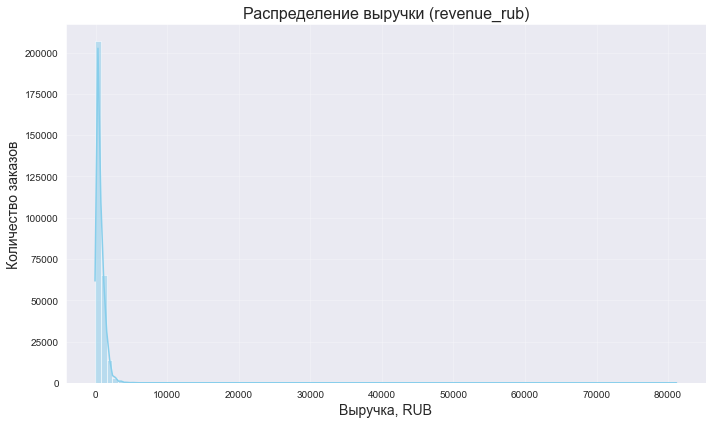

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df['revenue_rub'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Распределение выручки (revenue_rub)', fontsize=16)
plt.xlabel('Выручка, RUB', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


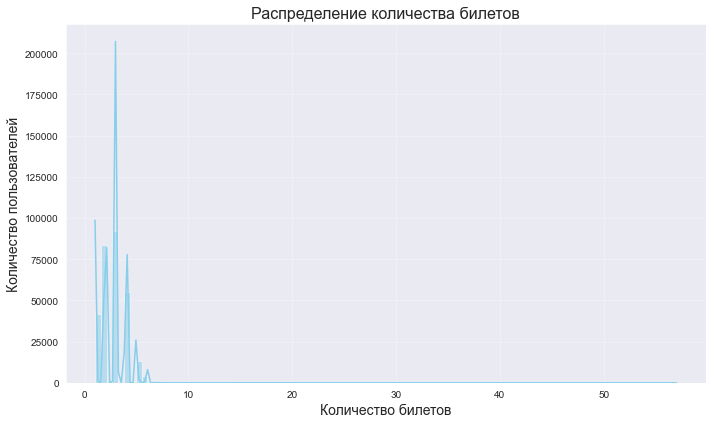

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df['tickets_count'].dropna(), bins=100, kde=True, color='skyblue')
plt.title('Распределение количества билетов', fontsize=16)
plt.xlabel('Количество билетов', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


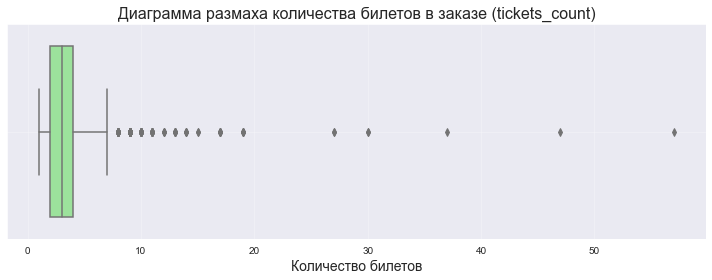

In [174]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df['tickets_count'].dropna(), color='lightgreen')
plt.title('Диаграмма размаха количества билетов в заказе (tickets_count)', fontsize=16)
plt.xlabel('Количество билетов', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

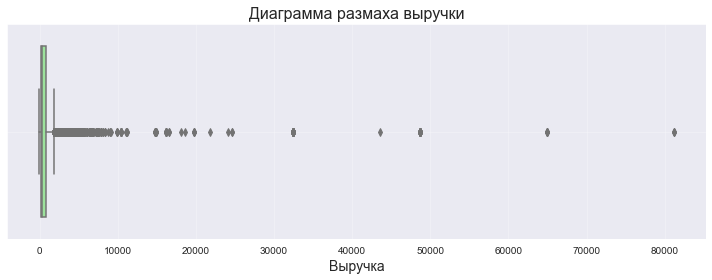

In [175]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df['revenue_rub'].dropna(), color='lightgreen')
plt.title('Диаграмма размаха выручки', fontsize=16)
plt.xlabel('Выручка', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Промежуточный вывод
- Выручка (revenue_rub):

Средняя выручка ~555 руб., медиана ~351 руб., что говорит о асимметричном распределении с длинным хвостом справа (есть высокие значения).

Минимальное значение отрицательное (-90,76 руб.) — это ошибка данных, которую нужно обработать (например, удалить или заменить на NaN).

Максимальная выручка (81 174 руб.) сильно превышает 99-й перцентиль (2 628 руб.), что указывает на явные выбросы.

- Количество билетов (tickets_count):

Среднее ~2.75 билета на заказ, медиана 3 билета.

Есть единичные выбросы (максимум 57 билетов), превышающие 99-й перцентиль (6 билетов), которые тоже можно считать аномалиями для анализа.

Удалим строки, в которых revenue_rub меньше нуля, а также отфильтруем по 99-ому процентелю, чтобы избавиться от выбросов в большую сторону.


In [176]:
df_clean = df[df['revenue_rub'] > 0].copy()

In [177]:
# Проверка количества строк с отрицательной выручкой
len(df_clean[df_clean['revenue_rub'] < 0])

0

In [178]:
# Найдем 99-ый процентиль
p99_revenue = df_clean['revenue_rub'].quantile(0.99)

In [179]:
df_clean = df_clean[df_clean['revenue_rub'] <= p99_revenue].copy()

In [180]:
print(f'Исходное количество строк: {len(df)}')
print(f'После удаления revenue < 0: {len(df[df["revenue_rub"] >= 0])}')
print(f'После фильтрации по 99 процентелю: {len(df_clean)}')

print(
    f'Удалено строк всего: {len(df) - len(df_clean)} '
    f'({(len(df) - len(df_clean)) / len(df):.2%})'
)

Исходное количество строк: 290611
После удаления revenue < 0: 290230
После фильтрации по 99 процентелю: 281879
Удалено строк всего: 8732 (3.00%)


## Исправление

### Выводы по предобработке данных

На этапе предобработки данных были выполнены следующие шаги:
- приведена выручка к единой валюте (российский рубль);
- проверены и проанализированы пропущенные значения;
- подтверждено, что пропуски в данных являются ожидаемыми и не требуют обработки;
- проверены категориальные признаки, ошибок и некорректных значений не выявлено;
- изучены распределения ключевых числовых показателей и обработаны выбросы.

После предобработки в данных сохранился достаточный объём наблюдений для проведения дальнейшего исследовательского анализа. Данные можно считать корректными и пригодными для изучения факторов, влияющих на возврат пользователей.


<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Предобработка данных <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> C задачей в целом справились, предобработку провели!

</div>

<div style="border-radius: 10px" class="alert alert-block alert-danger">
 
<b>Нужно доработать ❌:</b> 
    
* Что такое задача 2.2? Заголовок неинформативный. Он должен отражать то, что происходит внутри раздела - предобработка. При этом необходимо также написать мини-введение, зачем нам нужно провести предобработку.
    
    
* Решение по пропускам не пояснено, действительно ли они не требовали обработки? В отношении пропусков было бы не лишним убедиться, что они имеются только в количестве дней между заказами у первых заказов пользователей, то есть что проблемы здесь нет, это как раз будет обоснованием.
    
    
* Нет никакого вывода относительно проверки категориальных признаков, все ли там окей?
    
    
* Также не хватает итогового вывода. Что было проделано? Достаточно ли осталось данных для дальнейшего анализа?
    
</div>
    

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации 💡:</b> 
    
* Наш дальнейший анализ будет также касаться и количества дней между заказами, поэтому этот признак тоже важно проверить на предмет аномалий, есть ли в нем какие-то неадекватные значения, которые будут искажать наш анализ. 
    
    
* Для удобства анализа боксплот для определенного признака можно строить над или под гистограммой, чтобы можно было сопоставлять информацию из них ([пример](https://python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn/)). Можно даже создать пользовательскую функцию, которая будет принимать на вход признак и выводить для него сразу два типа визуализации в одном графике.


* При принятии решения относительно выбросов - оставляем или выбрасываем - стоит пояснять, во-первых, откуда они могли взяться, во-вторых, ввиду причины их возникновения, полезно ли будет их учитывание для целей нашего анализа.

    
* По итогу обработки количественных признаков можно также рассмотреть смену их типа - чтобы уменьшить объем памяти, занимаемой данными, можно понизить размерность числовых типов данных. Для смены числовых типов лучше использовать [to_numeric](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) с настройкой 'downcast', чтобы минимальная возможная точность определялась автоматически, и мк случайно бы не стерли вариативность (для количества дней только заранее нужно перевести в 'Int', который, в отличие от 'int', дозволяет присутствие пропусков, а уже потом даункастить).
    
    
* Также, если признак состоит из повторяющихся категорий, то ему можно назначить тип 'category'.


* Для лучшей навигации по проекту было бы неплохо создать четкую последовательность действий, выделить тематические подразделы.

    
* 'print' используется для простого текстового вывода. Но в средах с поддержкой rich output (Jupyter, IPython) также доступен 'display'. Для объектов, где важно сохранить форматирование или визуализацию (DataFrame, картинки, графики, HTML и т.д.) лучше использовать его.
    

* Если выводим какие-то значения на печать, в том числе стоит печатать, что это за значение, чтобы не приходилось разбираться в коде, чтобы это понять, а также форматировать сами значения. Для красоты и удобства дробные значения лучше округлять до знаков, которые могут представлять для нас интерес.

</div>


# Создание профиля пользователей

In [181]:
# Сортировка по дате
df_clean = df_clean.sort_values(['user_id', 'created_ts_msk'])

#### Исправлено среднее количество дней

In [182]:
# Создание нового датасета
user_profile = df_clean.groupby('user_id').agg(
        first_order_dt=('created_ts_msk', 'min'),
        last_order_dt=('created_ts_msk', 'max'),

        first_device=('device_type_canonical', 'first'),
        first_region=('region_name', 'first'),
        first_partner=('service_name', 'first'),
        first_event_genre=('event_type_main', 'first'),

        orders_cnt=('created_ts_msk', 'count'),
        avg_revenue=('revenue_rub', 'mean'),
        avg_tickets=('tickets_count', 'mean'),
        avg_time_between_orders=('days_since_prev', 'mean')
    ).reset_index()

На данном этапе данные агрегируются на уровне пользователей, так как дальнейшая цель анализа - изучить факторы, влияющие на возврат клиентов и общее количество их заказов.

Агрегация по 'user_id' позволяет:
- перейти от анализа отдельных заказов к анализу поведения пользователей;
- рассчитать агрегированные характеристики, описывающие профиль пользователя
- использовать полученные признаки для анализа возвратов и корреляционного анализа.

Таким образом, профиль пользователя является базовой единицей анализа в рамках данного исследования.


In [183]:
user_profile['is_two'] = (user_profile['orders_cnt'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['orders_cnt'] >= 5).astype(int)


In [184]:
user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_event_genre,orders_cnt,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,<NA>,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,<NA>,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


In [185]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21700 entries, 0 to 21699
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21700 non-null  object        
 1   first_order_dt           21700 non-null  datetime64[ns]
 2   last_order_dt            21700 non-null  datetime64[ns]
 3   first_device             21700 non-null  object        
 4   first_region             21700 non-null  object        
 5   first_partner            21700 non-null  object        
 6   first_event_genre        21700 non-null  object        
 7   orders_cnt               21700 non-null  int64         
 8   avg_revenue              21700 non-null  float64       
 9   avg_tickets              21700 non-null  float64       
 10  avg_time_between_orders  13457 non-null  Float64       
 11  is_two                   21700 non-null  int32         
 12  is_five                  21700 n

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Создание профиля пользователя <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">

<b>Отлично ✅:</b> 

* Результат корректный!


* Хорошо, что, ввиду использования агрегата 'first', не забываешь про сортировку заказов по времени!

</div>

<div style="border-radius: 10px" class="alert alert-block alert-danger">

<b>Нужно доработать ❌:</b> 
    
* Все шаги необходимо пояснять. Зачем мы решили агрегировать данные по пользователям?
    
    
* Среднее количество дней сейчас определено некорректно. Ты пытаешься уложить пересчитанную разницу в уже агрегированную по пользователям таблицу. Поэтому у тебя сейчас в строки с аналогичным индексом записываются значения количества дней между двумя конкретными заказами какого-то пользователя, но не среднее значение количества дней для нужного пользователя.
    
</div>


<div style="border-radius: 10px" class="alert alert-warning">

<b>Рекомендации💡:</b>
    
* Количество дней у нас уже тоже было посчитано, так что можно сократить растрату ресурсов ни дополнительные расчеты и объединения, но, действительно, данный показатель можно получить и средствами python.


* Есть довольно удобный метод [assign](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html), позволяющий дополнять таблицу новыми рассчитанными столбцами.

    Тогда создание всего профиля можно будет записать красивым и удобным по структуре кодом.
    
    <details> <summary> <span style='color:blue' > Развернуть подробнее. </span> </summary>
    
    '''python
    profiles = (df
            # В начале сортируем данные по дате совершения заказа, что найти первые признаки:
            .sort_values(by='order_ts')
            # Затем группируем по номеру пользователя и агрегируем данные:
            .groupby('user_id')
            .agg(
                # Находим первую и последнюю даты заказа:
                first_order_dt=('order_dt','min'),
                last_order_dt=('order_dt','max'),
                # Находим устройства, регион, название билетного партнера и жанр мероприятия первого заказа:
                first_device=('device_type_canonical','first'),
                first_region_name=('region_name','first'),
                first_service_name=('service_name','first'),
                first_event_type=('event_type_main','first'),
                # Подсчитваем количество заказов:
                total_orders=('order_id','nunique'),
                # Считаем статистику по заказам: средняя стоимость заказа, среднее количество билетов:
                avg_revenue_rub=('revenue_rub','mean'),
                avg_tickets_count=('tickets_count','mean'),
                # Считаем среднее количество дней между покупками:
                avg_days_since_prev=('days_since_prev','mean')
            )
            # Создаем два признака: совершил ли пользователь 2 / 5 и более заказов:
            .assign(
                is_two = lambda x: x['total_orders'] >= 2,
                is_five = lambda x: x['total_orders'] >= 5
            )
            .reset_index()
    )
    '''

    Таким же образом можно задать округление при необходимости.
    
    </details>

</div>

### Предобработка и анализ пользовательских профилей

#### На данном этапе анализ проводится на уровне пользователей, а не отдельных заказов.
#### Для этого формируется профиль пользователя — агрегированный набор характеристик, описывающий его поведение на платформе.

#### Предобработка пользовательских профилей необходима для:
#### - оценки качества и репрезентативности полученных данных;
#### - выявления аномалий и выбросов в агрегированных метриках;
#### - проверки, достаточно ли данных для проведения дальнейшего исследовательского анализа возвратов пользователей.



#### Найдем данные по пользователям

In [186]:
print(f"Всего пользователей: {len(user_profile)}")

Всего пользователей: 21700


In [187]:
avg_revenue_per_order = user_profile['avg_revenue'].mean()
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order}")

Средняя выручка с одного заказа: 551.8789863451586


In [188]:
print(f"Доля пользователей с 2 и более заказами: {user_profile['is_two'].sum() / len(user_profile): .2%}")

Доля пользователей с 2 и более заказами:  61.67%


In [189]:
print(f"Доля пользователей с 5 и более заказами: {user_profile['is_five'].sum() / len(user_profile): .2%}")

Доля пользователей с 5 и более заказами:  28.87%


# Изучим статистические показатели

In [190]:
user_profile[['orders_cnt', 'avg_tickets', 'avg_time_between_orders']].describe()

,orders_cnt,avg_tickets,avg_time_between_orders
count,21700.000000,21700.000000,13457.000000
mean,12.989816,2.746006,15.900942
std,119.766778,0.914290,22.341735
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.750000,8.000000
75%,5.000000,3.090909,20.500000
max,9987.000000,11.000000,148.000000


In [191]:
user_profile[[
    'orders_cnt',
    'avg_tickets',
    'avg_time_between_orders'
]].quantile([0.5, 0.9, 0.95, 0.99])

,orders_cnt,avg_tickets,avg_time_between_orders
0.50,2.00,2.75,8.0
0.90,15.00,4.00,41.5
0.95,31.00,4.00,61.5
0.99,150.01,5.00,113.0


## Статистические показатели по среднему числу билетов в принципе без отклонений, чего не скажешь о показателях по количеству заказов. В показателях по дням между заказами выделяется только максимальное значение - 137, но оно вполне является реалистичным (просто пользователь долго не делал заказ).
## В итоге в показателях по числу заказов: сильно выделяется максимальное значение - 9987, из-за чего достаточно большое СКО - около 120. Принят вывод о фильтрации данных по 95-тому процентелю.

In [192]:
p99_orders = user_profile['orders_cnt'].quantile(0.99)

user_profile_filtered = user_profile[user_profile['orders_cnt'] <= p99_orders].copy()

In [193]:
user_profile_filtered[['orders_cnt', 'avg_tickets', 'avg_time_between_orders']].describe()

,orders_cnt,avg_tickets,avg_time_between_orders
count,21483.000000,21483.000000,13240.000000
mean,6.404506,2.746183,16.153980
std,13.982574,0.918756,22.435742
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.333333
50%,2.000000,2.750000,8.394444
75%,5.000000,3.111111,21.000000
max,150.000000,11.000000,148.000000


In [194]:
print(f"Строк до фильтрации по 95-ому процентелю: {len(user_profile)}")
print(f"Строк после фильтрации по 95-ому процентелю: {len(user_profile_filtered)}")
print(f"Удалено строк: {len(user_profile) - len(user_profile_filtered)}")

Строк до фильтрации по 95-ому процентелю: 21700
Строк после фильтрации по 95-ому процентелю: 21483
Удалено строк: 217


### После фильтрации данные имеют намного меньше отклонений, все статистические показатели можно увидеть в выведенной таблице выше.

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ пользовательских профилей <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> Выполнены все необходимые шаги!
</div>
    
<div style="border-radius: 10px" class="alert alert-block alert-danger">

<b>Нужно доработать ❌:</b> Заголовк, опять же, не совсем подходящий, какие данные мы ищем? Здесь снова идет предобработка, но уже по пользователям. Опять же, не хватает мини-введения, зачем мы это делаем.
    
</div>
    
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 

* Возвращаемость на второй и на пятый заказ можно посчитать через функцию 'mean', поскольку наши поля бинарные, как раз получим долю единичек. 


* Чтобы сильно не растягивать код на множество ячеек, схожие по целям и подходам шаги лучше выполнять одной ячейкой. Например, можно было бы объединить первичный подсчет статистик.


* Решение по выбросам пояснено поверхностно. Откуда они могли взяться и нужны ли они нам для дальнейшего анализа?
    
    
* Было бы не лишним также проверить, насколько изменились показатели возвращаемости и средней выручки после фильтрации.

    
* Если выводим какие-то значения на печать, то стоит их не только подписывать, но и форматировать. Для красоты и удобства дробные значения лучше округлять до знаков, которые могут представлять для нас интерес.  
    
    
* Выводы не стоит оформлять через заголовки. Заголовки должны отражать структуру проекта для удобства навигации по нему, а не для ужирнения выводов.

</div>


# Исследовательский анализ данных

## Исследование признаков первого заказа и их связи с возвращением на платформу

#### В данном подразделе проводится изучение распределения пользователей по признакам, анализ возврата пользователей, проверка гипотез

In [195]:
# Группировка по типу первого мероприятия
total_users = len(user_profile_filtered)

grouped_by_first_genre = user_profile_filtered.groupby('first_event_genre').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False)
grouped_by_first_genre['share'] = grouped_by_first_genre['users_count'] / total_users
grouped_by_first_genre

,users_count,share
first_event_genre,,
концерты,9607,0.447191
другое,5223,0.243122
театр,4259,0.198250
стендап,1117,0.051995
спорт,765,0.035610
выставки,415,0.019318
ёлки,97,0.004515


In [196]:
# Группировка по типу устройства, с которого совершен первый заказ
grouped_by_first_device = user_profile_filtered.groupby('first_device').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False)
grouped_by_first_device['share'] = grouped_by_first_device['users_count'] / total_users
grouped_by_first_device

,users_count,share
first_device,,
mobile,17802,0.828655
desktop,3681,0.171345


In [197]:
# Группировка по типу первого региона
grouped_by_first_region = user_profile_filtered.groupby('first_region').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False)
grouped_by_first_region['share'] = grouped_by_first_region['users_count'] / total_users
print(grouped_by_first_region)

                          users_count     share
first_region                                   
каменевский регион               6973  0.324582
североярская область             3783  0.176093
широковская область              1234  0.057441
озернинский край                  678  0.031560
малиновоярский округ              527  0.024531
...                               ...       ...
залесский край                      2  0.000093
тихогорская область                 2  0.000093
верхозёрский край                   1  0.000047
сосноводолинская область            1  0.000047
яснопольский округ                  1  0.000047

[81 rows x 2 columns]


In [198]:
# Группировка по типу первого оператора
grouped_by_first_partner = user_profile_filtered.groupby('first_partner').agg(users_count=('user_id', 'count')).sort_values('users_count', ascending=False)
grouped_by_first_partner['share'] = grouped_by_first_partner['users_count'] / total_users
print(grouped_by_first_partner)

                        users_count     share
first_partner                                
билеты без проблем             4968  0.231253
мой билет                      2996  0.139459
лови билет!                    2801  0.130382
билеты в руки                  2548  0.118605
облачко                        2196  0.102220
весь в билетах                 1291  0.060094
лучшие билеты                  1183  0.055067
прачечная                       586  0.027277
край билетов                    460  0.021412
дом культуры                    358  0.016664
яблоко                          320  0.014895
тебе билет!                     310  0.014430
городской дом культуры          218  0.010148
мир касс                        213  0.009915
за билетом!                     204  0.009496
быстробилет                     165  0.007680
show_ticket                     157  0.007308
выступления.ру                   95  0.004422
восьмёрка                        86  0.004003
быстрый кассир                   6

### - По типу первого мероприятия выделяется сегмент с наибольшим числом пользователей - это концерты, составляет 44%, следующий во величине - всего 24.
### - По типу первого устройства выделяются мобильные телефоны - 83%.
### - По типу первого региона - каменевский регион, 32%, следующий по величине всего 17%.
### - По типу первого оператора данные распределены наиболее равномерно, есть один наиболее выделяющийся оператор - билеты без проблем (23%), но есть также еще около 6 операторов, которые имеют распределение от 5 до 13 %. Однако, данные все так же распределены неравномерно.

### В итоге, можно сделать вывод, что в каждом сегменте данные распределены неравномерно, везде есть выделяющийся сегмент с наибольшим числом пользователей.

In [199]:
# Анализ возврата пользователей

In [200]:
# Доля возврата пользователей по всему датасету
baseline_return_rate = user_profile_filtered['is_two'].mean()
round(baseline_return_rate, 4)

0.6128

In [201]:
# Универсальная функция для сегментов
def segment_return_rate(df, segment_col):
    segment_stats = (
        df.groupby(segment_col).agg(users_cnt=('user_id', 'count'), return_rate=('is_two', 'mean')).sort_values('users_cnt', ascending=False).reset_index()
    )

    return segment_stats

In [202]:
# По первому событию

event_return = segment_return_rate(user_profile_filtered, 'first_event_genre')
event_return

,first_event_genre,users_cnt,return_rate
0,концерты,9607,0.617779
1,другое,5223,0.594294
2,театр,4259,0.634891
3,стендап,1117,0.608774
4,спорт,765,0.549020
5,выставки,415,0.643373
6,ёлки,97,0.567010


In [203]:
# По первому устройству

device_return = segment_return_rate(user_profile_filtered, 'first_device')
device_return

,first_device,users_cnt,return_rate
0,mobile,17802,0.608078
1,desktop,3681,0.635697


In [204]:
# По первому событию

region_return = segment_return_rate(user_profile_filtered, 'first_region')
region_return.head(10)

,first_region,users_cnt,return_rate
0,каменевский регион,6973,0.619102
1,североярская область,3783,0.640497
2,широковская область,1234,0.645057
3,озернинский край,678,0.551622
4,малиновоярский округ,527,0.557875
5,шанырский регион,465,0.694624
6,светополянский округ,461,0.657267
7,травяная область,461,0.616052
8,речиновская область,445,0.638202
9,яблоневская область,411,0.593674


In [205]:
# По первому событию

partner_return = segment_return_rate(user_profile_filtered, 'first_partner')
partner_return.head(10)

,first_partner,users_cnt,return_rate
0,билеты без проблем,4968,0.597625
1,мой билет,2996,0.607810
2,лови билет!,2801,0.611210
3,билеты в руки,2548,0.629513
4,облачко,2196,0.613388
5,весь в билетах,1291,0.628970
6,лучшие билеты,1183,0.614539
7,прачечная,586,0.626280
8,край билетов,460,0.654348
9,дом культуры,358,0.648045


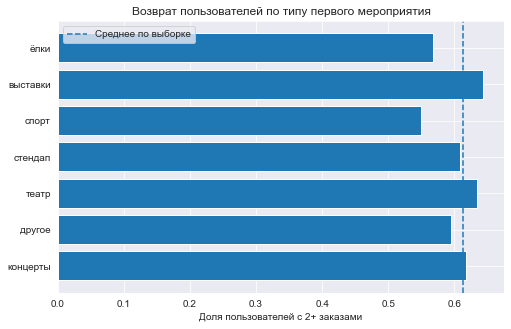

In [206]:
plt.figure(figsize=(8, 5))
plt.barh(
    event_return['first_event_genre'],
    event_return['return_rate']
)
plt.axvline(
    baseline_return_rate,
    linestyle='--',
    label='Среднее по выборке'
)
plt.xlabel('Доля пользователей с 2+ заказами')
plt.title('Возврат пользователей по типу первого мероприятия')
plt.legend()
plt.show()

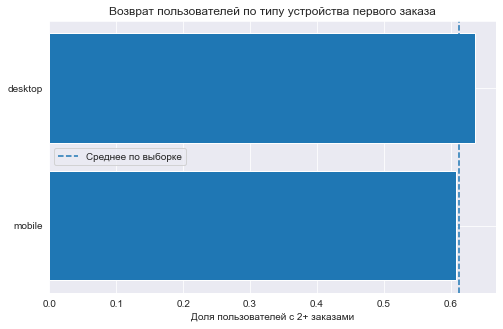

In [207]:
plt.figure(figsize=(8, 5))
plt.barh(
    device_return['first_device'],
    device_return['return_rate']
)
plt.axvline(
    baseline_return_rate,
    linestyle='--',
    label='Среднее по выборке'
)
plt.xlabel('Доля пользователей с 2+ заказами')
plt.title('Возврат пользователей по типу устройства первого заказа')
plt.legend()
plt.show()

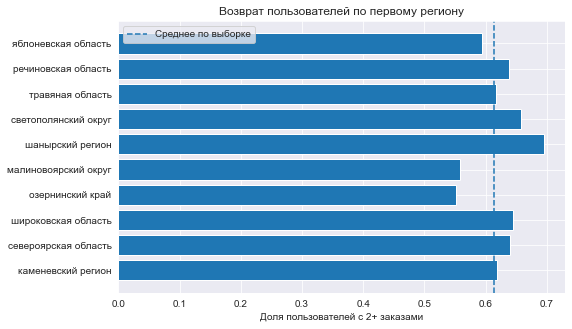

In [208]:
plt.figure(figsize=(8, 5))
plt.barh(
    region_return['first_region'].head(10),
    region_return['return_rate'].head(10)
)
plt.axvline(
    baseline_return_rate,
    linestyle='--',
    label='Среднее по выборке'
)
plt.xlabel('Доля пользователей с 2+ заказами')
plt.title('Возврат пользователей по первому региону')
plt.legend()
plt.show()

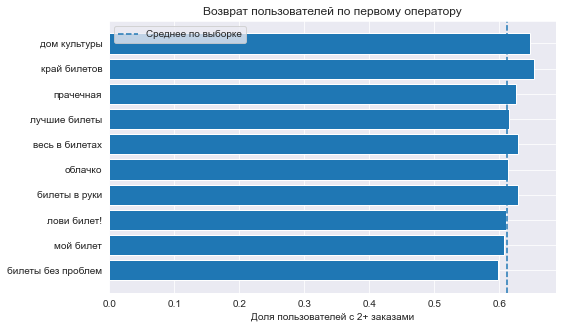

In [209]:
plt.figure(figsize=(8, 5))
plt.barh(
    partner_return['first_partner'].head(10),
    partner_return['return_rate'].head(10)
)
plt.axvline(
    baseline_return_rate,
    linestyle='--',
    label='Среднее по выборке'
)
plt.xlabel('Доля пользователей с 2+ заказами')
plt.title('Возврат пользователей по первому оператору')
plt.legend()
plt.show()

### В данных наблюдаются **успешные точки входа**, где пользователи возвращаются чаще среднего по выборке (**61,67%**):

### * **Театральные мероприятия** как первый опыт использования сервиса - доля повторных заказов **63,49%** при **4,3 тыс. пользователей**.
### * **Десктоп** как устройство первого заказа - **63,57%** при **3,7 тыс. пользователей**, что выше, чем у мобильных устройств (**60,81%**).
### * **Отдельные крупные регионы**, например **Североярская область** (**64,05%**, 3,8 тыс. пользователей) и **Широковская область** (**64,51%**, 1,2 тыс. пользователей).
### * **Ряд билетных операторов**, в частности **«Билеты в руки»** (**62,95%**, 2,5 тыс. пользователей) и **«Весь в билетах»** (**62,90%**, 1,3 тыс. пользователей).

### Сегменты с небольшим числом пользователей (сотни и менее), несмотря на более высокие значения доли возврата (до **65–69%**), не рассматриваются как статистически надёжные без дополнительной проверки.


## Проверка гипотез.
### Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

#### Нет, пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ реже, чем пользователи, оформившие свой первый заказ на концерты, ведь вероятность возврата на жанре "спорт" - 0.549, а вероятность возврата на жанре "концерты" - 0.6178

#### Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.
#### Возьмем топ 3 больших региона
#### - Каменевский регион - 6 973 пользователя, возврат 61,91%
#### - Североярская область — 3 783 пользователя, возврат 64,05%
#### - Широковская область — 1 234 пользователя, возврат 64,51%
#### Менее активные регионы:
#### - Озернинский край — 678 пользователей, возврат 55,16%
#### - Малиновоярский округ — 527 пользователей, возврат 55,79%
#### При этом в отдельных малых регионах (например, Шанырский регион, 465 пользователей) наблюдается высокий возврат (69,46%), но из-за небольшого размера сегмента такие значения могут быть нестабильными.
#### В целом гипотеза подтверждается частично, если не считать маленькие регионы, ведь данные по ним нестабильны.

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ сегментов пользователей <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">

<b>Нужно доработать ❌:</b> 
    
* Не хватает наименования подраздела внутри раздела с исследовательским анализом данных. Мини-введение - что и зачем в данном подразделе хотим исследовать?
    
    
* Разве после спортивных мероприятий возвращаются чаще?  

</div>    

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 

* Сейчас ты выполняешь большое количество однотипных действий. Чтобы немного облегчить код и уменьшить влияние человеческого фактора, стоит создать какую-нибудь пользовательскую функцию или зациклить выполнение определенного шаблона действий. Можно даже сразу объединить расчеты для первой и второй подзадачи, а потом уже переходить к визуализации и анализу. 


* В случае вывода неполного набора сегментов стоит указать, какой процент от выборки они составляют, чтобы было понимание, насколько большая часть данных осталась за пределами нашего обзора.


* Линию общей возвращаемости по выборке лучше отобразить другим цветом. В легенде стоит добавить, сколько она составляет.
    
 
* В выводах по первым двум частям было бы неплохо также попробовать предположить, почему мы могли получить то или иное распределение по сегментам и определенный уровень возвращаемости, почему показатели оказались именно такими. Это может быть полезно в плане развития стратегий по привлечению новых пользователей.

    
* С выводами по второй гипотезе не соглашусь. Действительно, важно учитывать размерность групп при сравнении долей! В менее популярных группах 1 дополнительный пользователь имеет больший вес, а потому показатель возвращаемости у таких категорий больше подвержен колебаниям, менее стабилен. Например, если бы у нас в группу с остальными регионами попало только два региона с одним пользователем, в одном вернулось 100%, в другом 0%, среднее 50%, показательно ли это? Чтобы сделать более осознанный вывод, можно, к примеру, построить скаттерплот с отображением размера региона и возвращаемости в нем, тогда будет видно всю картину в данных и можно будет сказать, что судя по относительно крупным регионам, в стабильности которых мы более менее уверены, такой зависимости не наблюдается.
    
    Но вообще, чтобы наверняка убедиться в том, что возвращаемость в непопулярных группах ниже, и это не случайное колебание, следует провести статистический тест, оценить значимость различий. Это будет изучаться в дальнейшем на курсе, там есть довольно много нюансов. 
    

* Каков итоговый вывод по анализу сегментов? Какие инсайты мы получили?

    
* Согласно стандартам оформления кода не стоит делать строки длиной более 79 символов, это портит его читаемость, вынуждает прокручивать ячейку.
    
    
* Моменты, поясненные ранее: вывод значений на печать, оформление выводов.
    
    
</div>

## Исследование поведения пользователей через показатели выручки и состава заказа
### В данном подразделе проводится отслеживание связи между средней выручкой сервиса с заказа и повторными заказами, сравнение распределения по средней выручке с заказа в двух группах пользователей, анализ влияния среднего количества билетов в заказе на вероятность повторной покупки.

In [210]:
one_order_users = user_profile_filtered[user_profile_filtered['is_two'] == 0]['avg_revenue']
repeat_users = user_profile_filtered[user_profile_filtered['is_two'] == 1]['avg_revenue']

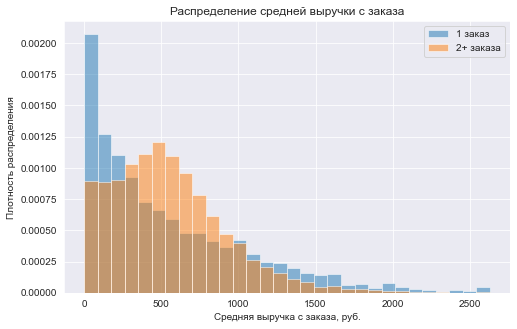

In [211]:
plt.figure(figsize=(8, 5))

plt.hist(
    one_order_users,
    bins=30,
    alpha=0.5,
    density=True,
    label='1 заказ'
)

plt.hist(
    repeat_users,
    bins=30,
    alpha=0.5,
    density=True,
    label='2+ заказа'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа')
plt.legend()
plt.show()

#### Пользователи с одним заказом (синим цветом)
#### Пик распределения - примерно 0–300 руб.
#### Большинство пользователей в этой группе делают небольшие по стоимости заказы.
#### Вернувшиеся пользователи (2+ заказа) (коричневым цветом)
#### Пик распределения - примерно 400–700 руб.
#### Распределение смещено вправо, есть более крупные заказы (500–1000 руб.) и длинный хвост вплоть до 2500+ руб.

In [212]:
# 2–4 заказа
group_2_4 = user_profile_filtered[(user_profile_filtered['orders_cnt'] >= 2) & (user_profile_filtered['orders_cnt'] <= 4)]['avg_revenue']

# 5+ заказов
group_5_plus = user_profile_filtered[user_profile_filtered['orders_cnt'] >= 5]['avg_revenue']

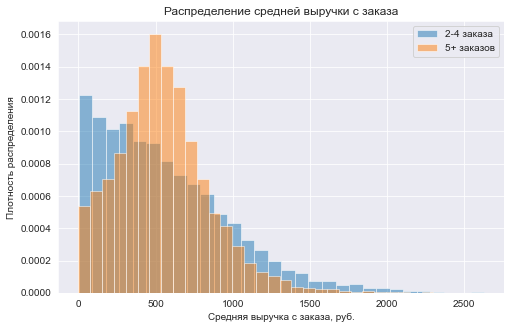

In [213]:
plt.figure(figsize=(8, 5))

plt.hist(
    group_2_4,
    bins=30,
    alpha=0.5,
    density=True,
    label='2-4 заказа'
)

plt.hist(
    group_5_plus,
    bins=30,
    alpha=0.5,
    density=True,
    label='5+ заказов'
)

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа')
plt.legend()
plt.show()

#### Пользователи с 2-4 заказами (синим цветом)
#### Пик распределения - примерно 0–400 руб. Больше всего заказов со стоимостью 0-100.
#### Большинство пользователей в этой группе делают небольшие по стоимости заказы (чаще всего 0-400 рублей), также имеет хвост вправо вплоть до 2300 руб.
#### 5+ заказов (коричневым цветом)
#### Пик распределения - примерно 400–700 руб. Больше всего заказов со стоимостью 500.
#### Распределение смещено вправо и также имеет хвост вплоть до 1700+ руб.

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ взаимосвязи средней выручки и числа заказов <a class="tocSkip"></h4>

    
<div style="border-radius: 10px" class="alert alert-block alert-danger">

<b>Нужно доработать ❌:</b> Мини-введение - что и зачем здесь исследуем?
    
</div>
    
    
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> 
    
* С этой задачей справились! 
    
    
* Плюсик за грамотное оформление графиков - заголовок, подписи осей, легенда, поправка на размер выборки ('density').

</div>


<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b>  
    
* Для формирования выборок в обоих случаях можно было использовать ранее созданные признаки 'is_two' и 'is_five'. Если в 'is_two' нолик - это пользователь с одним заказом, если единичка - заказов два и больше. При комбинации с 'is_five' также можно было бы определить группу с 2-4 заказами - в 'is_two' в таком случае будет единичка, а в 'is_five' - нолик. С их использованием оба графика можно будет построить разом с помощью одной функции 'seaborn'.
    
    
* Чтобы удобно было сопоставлять доли пользователей по диапазонам цен, можно настроить единый размер бинов ('bins = 50' фиксирует количество бинов, но размер между сегментами будет отличаться, поскольку диапазон значений у них разный). Для этого в 'bins' можно передать границы для формирования бинов с шагом: 'bins = range(min_value, max_value+1, 50)', максимальное и минимальное значения при этом определяем на всей выборке, а не отдельно для каждого.


* Выводы крайне поверхностные. Сейчас ты просто пересказываешь результаты, но это не является аналитикой. Анализ заключается в интерпретации полученных результатов, вытаскивании инсайтов, составлении какого-то представления/характеристики на основе полученных данных, пояснении того, что для нас это значит, почему могло получиться именно так. Именно эти суждения для нас ценны, цифры являются лишь подкреплением. В данном случае подобные рассуждения могут быть полезны в плане развития стратегий по привлечению новых пользователей.


* Каков итоговый вывод по анализу выручки? Какие инсайты мы получили?
    
    
* Моменты, поясненные ранее: оформление выводов, длина строки кода.
    
</div>

## Анализ влияния среднего количества билетов в заказе на вероятность повторной покупки.
### В данном подразделе проводится изучение распределения пользователей по среднему количеству билетов, а также проводится разделение пользователей на несколько сегментов и для каждого сегмента проводится подсчет общего числа пользователей и доли пользователей, совершивших повторные заказы.

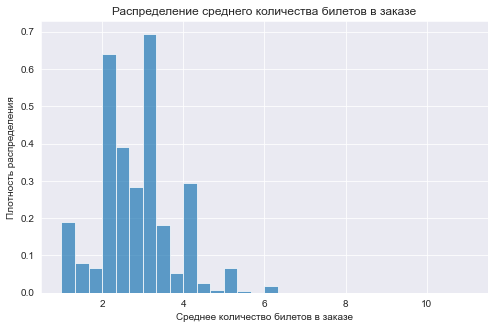

In [214]:
plt.figure(figsize=(8, 5))
plt.hist(user_profile_filtered['avg_tickets'], bins=30, density=True, alpha=0.7)
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Плотность распределения')
plt.title('Распределение среднего количества билетов в заказе')
plt.show()

In [215]:
user_profile_filtered['avg_tickets'].describe()

count    21483.000000
mean         2.746183
std          0.918756
min          1.000000
25%          2.000000
50%          2.750000
75%          3.111111
max         11.000000
Name: avg_tickets, dtype: float64

In [216]:
print(user_profile_filtered['avg_tickets'].mode())

0    3.0
dtype: float64


In [217]:
user_profile_filtered['avg_tickets'].value_counts().head(10)

3.000000    4140
2.000000    3718
4.000000    2045
1.000000    1326
2.500000    1148
3.500000     659
2.666667     530
5.000000     463
2.333333     458
1.500000     415
Name: avg_tickets, dtype: int64

#### Самое часто встречающееся число билетов в заказе - 3, следующее по количеству - 2.
#### Распределение смещено вправо, имеется два больших пика в двойке и тройке. Минимальное значение - 1, маусимальное - 11.

In [218]:
user_profile_filtered['tickets_segment'] = pd.cut(
    user_profile_filtered['avg_tickets'],
    bins=[1, 2, 3, 5, 11],
    right=True,
    include_lowest=True,
    labels=[
        '1–2 билета',
        '2–3 билета',
        '3–5 билетов',
        '5+ билетов'
    ]
)
user_profile_filtered.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_event_genre,orders_cnt,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,tickets_segment
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,<NA>,0,0,3–5 билетов
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,1,0,2–3 билета
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,1,0,2–3 билета
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,<NA>,0,0,3–5 билетов
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0,1–2 билета


In [219]:
segment_stats = user_profile_filtered.groupby('tickets_segment').agg(
    users_count=('user_id', 'count'),
    returned_share=('is_two', 'mean')
)
segment_stats

,users_count,returned_share
tickets_segment,,
1–2 билета,6109,0.400229
2–3 билета,9833,0.742195
3–5 билетов,5347,0.628203
5+ билетов,194,0.324742


#### Пользователи распределены по сегментам неравномерно. Самое большое количество пользователей в сегменте 2-3 билета (9833), а самое маленькое в 5+ билетов, что логично, ведь цена на 5+ билетов не всем "под силу".
#### Нельзя сказать, что есть сегменты с аномально низкой или аномально высокой долей повторных покупок, однако в сегменте 2-3 билета, доля повторных покупок самая большая - 0.74

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ взаимосвязи количества билетов в заказе и возвращаемости <a class="tocSkip"></h4>

    
<div style="border-radius: 10px" class="alert alert-block alert-danger">

<b>Нужно доработать ❌:</b> Нет ни позаголовка, ни мини-введения.
    
</div>
    
    
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b>

* Здесь в целом все окей, справились! 


* Здорово, что используешь удобный метод [сut](https://pandas.pydata.org/docs/reference/api/pandas.cut.html).
 
</div>
    
    
<div style="border-radius: 10px" class="alert alert-warning">
    
<b>Рекомендации💡:</b>


* Необходимо только пересмотреть настройки параметров, сейчас у тебя первый сегмент включает обе границы, а последний не включает их вовсе. Сейчас по всему диапазону у нас есть фиксированное ограничение снизу, и нет ограничения сверху, по такой же логике стоит формировать и сегменты - включать левую границу и исключать правую.


* Для наглядности и удобства анализа было бы не лишним визуализировать результаты.


* В выводах, опять же, не хватает предположений, что это за группы у нас сформировались (что за типы клиентов), и почему получились именно такие результаты по возвращаемости, что это значит для бизнеса?. Это может быть полезно в плане развития стратегий по привлечению новых пользователей.
    
    
* Моменты, поясненные ранее: оформление выводов.

</div>

## Исследование временных характеристик первого заказа и их влияния на повторные покупки

### В данном подразделе проводится анализ того, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей; изучение того, как средний интервал между заказами влияет на удержание клиентов.

In [220]:
user_profile_filtered['first_order_weekday'] = user_profile_filtered['first_order_dt'].dt.day_name()
user_profile_filtered.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_event_genre,orders_cnt,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five,tickets_segment,first_order_weekday
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,<NA>,0,0,3–5 билетов,Tuesday
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,1,0,2–3 билета,Tuesday
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,1,0,2–3 билета,Saturday
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,<NA>,0,0,3–5 билетов,Thursday
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0,1–2 билета,Sunday


In [221]:
weekday_stats = (
    user_profile_filtered
    .groupby('first_order_weekday')
    .agg(users_cnt=('user_id', 'count'), returned_share=('is_two', 'mean'))
    .reset_index()
    .sort_values(by='users_cnt', ascending=False)

)
weekday_stats

,first_order_weekday,users_cnt,returned_share
2,Saturday,3292,0.627886
0,Friday,3230,0.599071
5,Tuesday,3157,0.617358
4,Thursday,3098,0.594900
6,Wednesday,3048,0.621719
1,Monday,2901,0.626336
3,Sunday,2757,0.601741


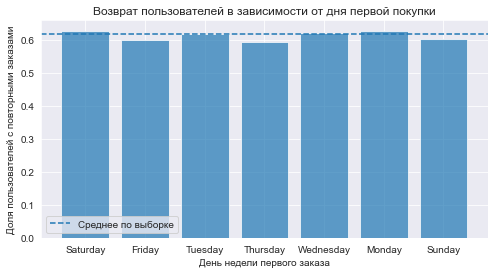

In [222]:
plt.figure(figsize=(8, 4))
plt.bar(
    weekday_stats['first_order_weekday'],
    weekday_stats['returned_share'],
    alpha=0.7
)
plt.axhline(
    y=user_profile['is_two'].mean(),
    linestyle='--',
    label='Среднее по выборке'
)
plt.ylabel('Доля пользователей с повторными заказами')
plt.xlabel('День недели первого заказа')
plt.title('Возврат пользователей в зависимости от дня первой покупки')
plt.legend()
plt.show()


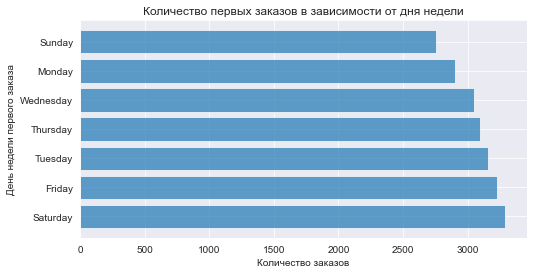

In [223]:
plt.figure(figsize=(8, 4))
plt.barh(
    weekday_stats['first_order_weekday'],
    weekday_stats['users_cnt'],
    alpha=0.7
)
plt.xlabel('Количество заказов')
plt.ylabel('День недели первого заказа')
plt.title('Количество первых заказов в зависимости от дня недели')
plt.show()


#### По результатам анализа понятно, что день недели, в который совершена первая покупка, не влияет на то, вернется ли пользователь, ведь вероятность возврата почти в каждый день недели равна около 60%

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ возвращаемости по дням недели  <a class="tocSkip"></h4>

    
<div style="border-radius: 10px" class="alert alert-block alert-danger">

<b>Нужно доработать ❌:</b> Нет ни позаголовка, ни мини-введения.
    
</div>
    
    
<div style="border-radius: 10px" class="alert alert-success">
<b>Отлично ✅:</b> По расчетам все корректно. Различия по дням недели все же наблюдаются, хотя и не очень заметные. Чтобы судить более однозначно, было бы неплохо сопроводить сравнение оценкой статистической значимости. Это будет изучаться далее на курсе.

</div>
<div style="border-radius: 10px" class="alert alert-warning">
    
<b>Рекомендации 💡:</b>


* Столбики на графике стоит расположить в логическом порядке, чтобы можно было отследить динамику.


* В выводах было бы неплохо также предположить, почему в топ и антитоп (которые все-таки создается, хотя и на так явно) выбиваются определенные дни недели? Какие суждения относительно этого можно выстроить?

    
* Моменты, поясненные ранее: оформление выводов.

</div>

Изучение того, как средний интервал между заказами влияет на удержание клиентов.
- Рассчет среднего времени между заказами для двух групп пользователей:
2–4 заказа;
5 и более заказов.
- Исследование того, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.


In [224]:
group_2_4 = user_profile_filtered[
    (user_profile_filtered['orders_cnt'] >= 2) &
    (user_profile_filtered['orders_cnt'] <= 4)
]

group_5_plus = user_profile_filtered[
    user_profile_filtered['orders_cnt'] >= 5
]

In [225]:
interval_stats = pd.DataFrame({
    'group': ['2–4 заказа', '5+ заказов'],
    'users_cnt': [
        group_2_4.shape[0],
        group_5_plus.shape[0]
    ],
    'avg_days_between_orders': [
        group_2_4['avg_time_between_orders'].mean(),
        group_5_plus['avg_time_between_orders'].mean()
    ]
})

interval_stats

,group,users_cnt,avg_days_between_orders
0,2–4 заказа,7118,21.219315
1,5+ заказов,6047,9.890956


Исправлено
- Среднее время между заказами у группы 2-4 дня больше в 2+ раза, чем у группы с 5+ заказами.

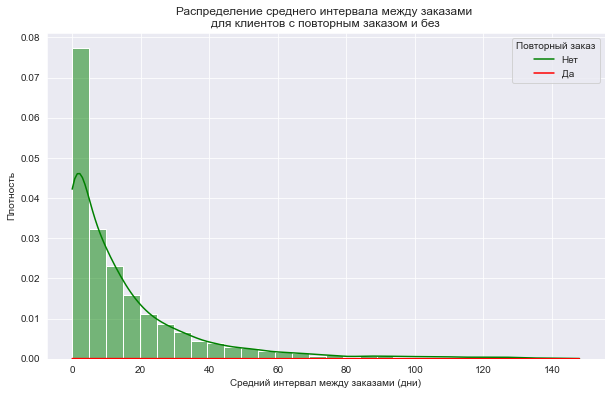

In [226]:
plt.figure(figsize=(10,6))
sns.histplot(data=user_profile_filtered, x='avg_time_between_orders', hue='is_two',
             bins=30, kde=True, stat='density', palette=['red','green'], alpha=0.5)

plt.xlabel('Средний интервал между заказами (дни)')
plt.ylabel('Плотность')
plt.title('Распределение среднего интервала между заказами \nдля клиентов с повторным заказом и без')
plt.legend(title='Повторный заказ', labels=['Нет','Да'])
plt.show()

In [227]:
bins = [0, 30, 60, 90, np.inf]
labels = ['<=30_days', '31-60_days', '61-90_days', '>90_days']
user_profile_filtered['interval_group'] = pd.cut(user_profile_filtered['avg_time_between_orders'], bins=bins, labels=labels, right=True)


In [228]:
repeat_probs = user_profile_filtered.groupby('interval_group')['is_two'].mean().reset_index()
repeat_probs.rename(columns={'is_two': 'repeat_probability'}, inplace=True)

In [229]:
repeat_probs

,interval_group,repeat_probability
0,<=30_days,0.997847
1,31-60_days,0.986283
2,61-90_days,0.974619
3,>90_days,0.967320


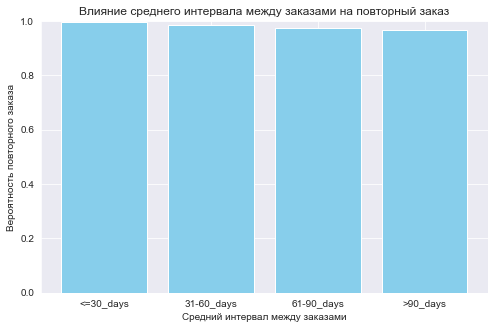

In [230]:
plt.figure(figsize=(8,5))
plt.bar(repeat_probs['interval_group'], repeat_probs['repeat_probability'], color='skyblue')
plt.xlabel('Средний интервал между заказами')
plt.ylabel('Вероятность повторного заказа')
plt.title('Влияние среднего интервала между заказами на повторный заказ')
plt.ylim(0,1)
plt.show()


Результаты анализа показывают, что вероятность повторного заказа снижается по мере увеличения интервала времени между заказами.

Это позволяет рассматривать длительность интервала после предыдущего заказа как индикатор снижения пользовательской активности. В частности, при интервалах более 60–90 дней вероятность самостоятельного возвращения пользователя становится заметно ниже.

Таким образом, интервал времени после последнего заказа может быть использован для определения момента, когда вероятность самостоятельного возвращения пользователя снижается, и возникает необходимость подключения дополнительных маркетинговых механик для стимулирования повторной покупки.



<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ возвращаемости по количеству дней между заказами <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">

<b>Нужно доработать ❌:</b> 
    
* Нет ни позаголовка, ни мини-введения.
    
    
* Анализ нужно пересмотреть, поскольку среднее количество дней сейчас определено некорректно.
    
    
* Вывод банален. Логично, что на ограниченном промежутке времени у клиента с большим количеством заказов интервалы будут меньше. Поэтому здесь стоит делать обратный ход - подумать, как по интервалу времени после очередного заказа можно определять, есть ли шанс, что клиент еще вернется самостоятельно, или пора подключать стратегии для вовлечения в новый заказ.
    
</div>
    
    
<div style="border-radius: 10px" class="alert alert-warning">
    
<b>Рекомендации 💡:</b>

* Здесь опять же можно было удобно использовать признаки 'is_two'и 'is_five' и задействовать 'seaborn'.


* Особенно важно в данном случае настроить единый размер бинов для гистограмм. Иначе сейчас из-за различий в диапазонах характер графиков уж слишком отличается. Также стоит добавить сетку, чтобы удобнее было ориентироваться на графике.
    
    
* На график стоит добавить сетку для лучшей ориентации.
    
    
* Моменты, поясненные ранее: длина строки кода, оформление выводов.
   
</div>


### Корреляционный анализ количества покупок и признаков пользователя
В этом разделе проводится корреляционный анализ признаков профиля пользователя и характеристик первого заказа с общим количеством совершённых покупок. Для анализа используется коэффициент phi_k, позволяющий учитывать как числовые, так и категориальные признаки.

С учётом возможной концентрации пользователей с одним заказом дополнительно будет выполнен анализ по сегментам пользователей, разделённых по числу заказов.


In [231]:
interval_cols = ['orders_cnt', 'avg_revenue', 'avg_tickets', 'avg_time_between_orders', 'is_two']

In [232]:
df_phik = user_profile_filtered.drop(columns=['first_order_dt', 'last_order_dt', 'user_id'])

In [233]:
phik_m = df_phik.phik_matrix(interval_cols=interval_cols)

In [234]:
print(phik_m['orders_cnt'].sort_values(ascending=False).drop('orders_cnt'))

is_five                    0.636809
is_two                     0.319584
avg_time_between_orders    0.294855
avg_tickets                0.230616
avg_revenue                0.225704
interval_group             0.219600
tickets_segment            0.216721
first_region               0.124709
first_order_weekday        0.053428
first_partner              0.030954
first_event_genre          0.028761
first_device               0.015655
Name: orders_cnt, dtype: float64


In [235]:
df_phik['orders_segment'] = pd.cut(
    df_phik['orders_cnt'],
    bins=[0, 1, 4, df_phik['orders_cnt'].max()],
    labels=['1_order', '2_4_orders', '5+_orders']
)

In [236]:
# Исправлено
phik_matrix = df_phik.phik_matrix(interval_cols=interval_cols)


In [237]:
orders_segment_corr = (
    phik_matrix['orders_segment']
    .drop('orders_segment')
    .sort_values(ascending=False)
)
print(orders_segment_corr)

is_two                     1.000000
is_five                    1.000000
orders_cnt                 0.502275
avg_time_between_orders    0.396198
avg_tickets                0.382675
interval_group             0.367597
avg_revenue                0.326254
tickets_segment            0.255670
first_region               0.126744
first_partner              0.083251
first_event_genre          0.043640
first_order_weekday        0.030784
first_device               0.015572
Name: orders_segment, dtype: float64


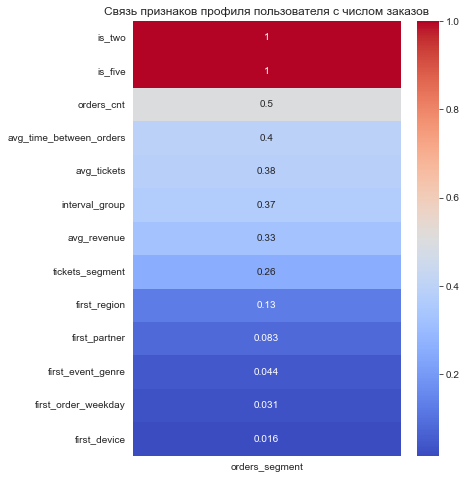

In [238]:
# Исправлено
plt.figure(figsize=(6, 8))
sns.heatmap(
    orders_segment_corr.to_frame(),
    annot=True,
    cmap='coolwarm',
    cbar=True
)
plt.title('Связь признаков профиля пользователя с числом заказов')
plt.show()


#### Без разделения на сегменты наиболее связаны с количеством заказов такие столбцы: is_five, is_two, avg_tickets, avg_revenue, tickets_segment, first_region
#### - С разделением на сегменты: столбцы is_two и is_five имеют прямую 100% корреляцию с сегментами, также столбцы orders_cnt, avg_time_between_orders, avg_tickets, interval_group, avg_revenue а также tickets_segment имеют также положительную немаленькую корреляцию (0.5 - 0.26)

<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Анализ корреляции <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-block alert-danger">

<b>Нужно доработать ❌:</b> 
    
* Нет ни заголовка, ни мини-введения.
    
    
* Обрати внимание, что сейчас мы исследуем влияние факторов на то, насколько активным окажется пользователь (с точки зрения количества заказов), поэтому сегментация количества заказов нам нужна была для того, чтобы сделать интервалы более сбалансированными по составу в противовес тому биннингу, который происходит автоматически в алгоритме Phik, когда мы передаем ему количественный признак. Отсюда следует, что корреляцию нужно проверять не внутри сегментов между факторами, а факторов с самими сегментами.
    
    
* Нужно будет пересмотреть результаты в отношении среднего количества дней.
    
</div>

   
<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 

* В проверке 'is_two' 'is_five' смысла нет - это производные признака количества заказов, они не расскажутт нам ничего интересного. Причем обращу внимание, что это не количественные признаки, которые требуется разбить на интервалы, в 'interval_cols' такие не указываем.


* Для удобства анализа стоит выводить значения корреляции в ячейках тепловой карты. Чтобы их отобразились, нужно добавить параметр 'annot = True'.


* Расцветку для тепловой карты имеет смысл выбирать трехцветную, если диапазон возможных значений от -1 до 1 (например, синий, белый, красный, белый при этом в нуле), и двухцветную, если от 0 до 1 (в 0 - белый, в 1 - красный). Поскольку на 0 будет нейтральный цвет, величину корреляции можно будет воспринимать через интенсивность цвета, а по самому цвету - положительная она или отрицательная. Phik корреляция имеет только положительные значения.
       

*  В выводах было бы неплохо провести параллель с нашими предыдущими шагами анализа. Прокомментировать, почему высокая корреляция получается с одними признаками и низкая с другими. Что по итогу важно для манипулирования возвращаемостью клиентов, а что нет?
    
    
* Напоминаю, что Phik корреляция всегда имеет положительные значения. Данная корреляция не говорит о направленности взаимосвязи, только о ее силе. Поэтому некорректно строить суждения, что чем больше что-то одно, тем больше/меньше что-то другое. О направленности мы можем лишь предполагать, полагаясь на логику и здравый смысл, либо же подкреплять суждения результатами предыдущих шагов. Если ты хочешь добавить про направленность, то важно оставить пояснение, на основе чего мы это говорим.

    

</div>

## Общий вывод

### Данные и подготовка

В работе использовались данные о заказах пользователей билетного сервиса: информация о первом заказе, профиле пользователя, количестве заказов, выручке, количестве билетов и временных характеристиках.
Перед анализом данные были подготовлены:

* выручка приведена к единой валюте (рубли);
* построен профиль пользователей на уровне 'user_id';
* отфильтрованы выбросы по количеству заказов и средним интервалам между покупками;
* рассчитаны дополнительные признаки: средняя выручка, среднее число билетов, интервалы между заказами, признаки повторных покупок;
* пользователи сегментированы по количеству заказов.

После очистки данные стали более устойчивыми, без аномальных значений, что позволило корректно проводить дальнейший анализ.

### Основные результаты анализа

**Общая структура данных**

* В выборке преобладают пользователи с **одним заказом**, что создаёт сильный перекос в распределении 'total_orders'.
* Пользователи с 2–4 и 5+ заказами составляют меньшую, но наиболее ценную с точки зрения бизнеса часть аудитории.
* Были изучены ключевые статистики: среднее число заказов, средний чек, количество билетов, интервалы между покупками.

**Возврат пользователей**

* Вероятность повторного заказа выше у пользователей с:

  * более высоким средним чеком;
  * большим количеством билетов в заказе;
  * меньшими интервалами между покупками.
* Первый заказ играет важную роль в формировании дальнейшего поведения.

**Связь выручки и состава заказа с повторными покупками**

* Средняя выручка и среднее количество билетов в заказе умеренно связаны с вероятностью повторных покупок.
* Пользователи, которые сразу покупают больше билетов или более дорогие билеты, чаще возвращаются.

**Временные характеристики**

* Интервалы между заказами являются одним из ключевых факторов удержания: чем они меньше, тем выше вероятность повторной покупки.
* День недели первого заказа влияет слабо, но в данных есть дни, которые можно считать более «успешными точками входа».

**Корреляционный анализ**

* Профильные признаки (устройство, партнёр, жанр первого события) слабо связаны с числом заказов.
* Наибольшую связь с количеством заказов показывают **поведенческие признаки**, а не характеристики профиля.
* Из-за преобладания пользователей с одним заказом корреляция на всей выборке занижена, поэтому была проведена сегментация по числу заказов.
* В сегментах с 2–4 и 5+ заказами зависимости между поведенческими признаками становятся заметно сильнее.

## Итоговые выводы

* Основной фактор роста числа заказов — **поведение пользователя**, а не его демографический или технический профиль.
* Первый заказ критически важен: именно он задаёт дальнейший сценарий взаимодействия пользователя с сервисом.
* Пользователи с одним заказом сильно «размывают» корреляционные зависимости, но именно они являются главным резервом роста.


## Рекомендации заказчику

1. **Сфокусироваться на пользователях с 1 заказом**
   Это самый массовый сегмент и основной источник потенциального роста. Для них стоит:

   * запускать триггерные коммуникации после первого заказа;
   * стимулировать повторную покупку в короткий срок.

2. **Усилить работу с сегментом 2–4 заказа**
   Это переходный сегмент, где поведенческие паттерны уже формируются:

   * персональные предложения;
   * бонусы за повторные покупки;
   * рекомендации похожих мероприятий.

3. **Закреплять лояльность пользователей с 5+ заказами**
   Это наиболее ценные клиенты:

   * программы лояльности;
   * ранний доступ к мероприятиям;
   * персонализированные подборки.

4. **Оптимизировать первый заказ**
   Стоит стимулировать:

   * покупку большего количества билетов;
   * более вовлекающий первый опыт (успешные жанры и форматы).

В целом результаты показывают, что рост удержания и числа заказов достигается не за счёт изменения профиля пользователя, а за счёт управления пользовательским поведением и качеством первого и повторных взаимодействий с сервисом.


<div style="border:solid #D3D3D3 2px;  border-radius: 10px; padding: 15px">
<h3> Комментарий ревьюера <a class="tocSkip"></h3>
<h4> Итоговые выводы <a class="tocSkip"></h4>

<div style="border-radius: 10px" class="alert alert-success"> Предложенные рекомендации неплохи и могут быть непосредственно реализованы в маркетинговых стратегиях подогревания и удержания. 

</div>

<div style="border-radius: 10px" class="alert alert-warning">
<b>Рекомендации💡:</b> 
    
* Свои суждения важно подкреплять конкретными значениями, чтобы они не воспринимались субъективным взглядом.
    
    
* Выводы противоречивые - сначала говорим, что первый заказ играет важную роль, а потом, что данные характеристики мало влияют на дальнейшее поведение.
    
    
* Выводы не совсем точны - разве большое количество билетов будет говорить о том, что это хороший пользователь в перспективе?


</div>

<div style="border:solid Green 2px; border-radius: 10px;  padding: 40px">
<h3>Общий вывод по проекту <a class="tocSkip"></h3>
    
Иван, спасибо за твой проект! У тебя неплохая работа, двигаемся в нужном направлении! Однако есть еще моменты, которые требуют твоего внимания. Кратко пройдусь по впечатлениям. 
    
**Полнота:** все требуемые задачи были выполнены!
    
**Корректность:** 

* <span style="color:Red;">Необходимо засекретить подключение к БД, чтобы не скомпрометировать явки и пароли. Не забываем опубликовать файл в Git.</span>
* <span style="color:Red;">Необходимо скорректировать расчет среднего количества дней между заказами, после чего пересмотреть его анализ.</span>
* <span style="color:Red;">Необходимо пересмотреть выводы в отношении гипотезы по сегментам, сформированным первыми заказами.</span>
* <span style="color:Red;">Необходимо пересмотреть оценку корреляции.</span>

**Аналитическая проницательность:** ты верно подмечаешь ключевые нюансы данных. Но это чистое фиксирование статистики, без анализа. Стоит углубить суждения, фиксировать не только то, что наблюдаем, но и предполагать, почему получилось именно так, что это означает для бизнеса. Без самой аналитики проект бесполезен.
    
**Эффективность кода:** по этому критерию в целом все окей! В некоторых местах можно использовать чуть более удобные и компактные методы, зафункционалить повторяющиеся действия. Стоит обратить внимание на длину строки с кодом.
    
**Оформление:** им тоже важно не пренебрегать! Оформление тесно связано с удобством восприятия предоставляемой информации и созданием впечатления о работе. Пока что в этом плане твоя работа очень хромает <span style="color:Red;">(смотри по ходу работы)</span>.

    
**Желаю удачи и жду твой проект на повторное ревью!** 😉
    
<img src="https://99px.ru/sstorage/86/2015/12/image_86271215043043632690.gif" />